<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_06_GliaContaminationCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy anndata

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import scanpy as sc
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [4]:
file_path = "/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_pre_tokenization.pkl"

with open(file_path, 'rb') as f:
    adata = pickle.load(f)

adata

AnnData object with n_obs × n_vars = 133957 × 41625
    obs: 'libname', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'date', 'Donor_Age', 'Donor_PMI', 'Status', 'Cause_of_Death', 'FACS_Classification', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [38]:
# Normalize total counts per cell to 10,000 counts
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data (adds a new scale)
sc.pp.log1p(adata)

# add rank normalization so it is comparable to geneformers representation

# Convert matrix to dense format if needed (careful with memory)
X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Rank-transform each cell (row-wise)
ranked_data = np.apply_along_axis(lambda x: pd.Series(x).rank(ascending=True).values, axis=1, arr=X_dense)

# adata.layers["rank"] = adata.X.argsort().argsort() / adata.X.shape[1]

# Store the rank-transformed data in a new layer or overwrite existing
adata.layers["rank"] = ranked_data

adata.obs.rename(columns={"disease__ontology_label": "disease_state"}, inplace=True)
adata.obs.rename(columns={"total_counts": "n_counts"}, inplace=True)

In [39]:
# grab dopamine subset

dopamine_subset = adata[adata.obs["leiden"] == "7"].copy()
print(dopamine_subset.obs['disease_state'].value_counts())

#grab microglia subset
microglia_subset = adata[adata.obs["leiden"] == "5"].copy()
print(microglia_subset.obs['disease_state'].value_counts())

disease_state
normal               14879
Parkinson disease     2215
Name: count, dtype: int64
disease_state
normal               4419
Parkinson disease    2047
Name: count, dtype: int64


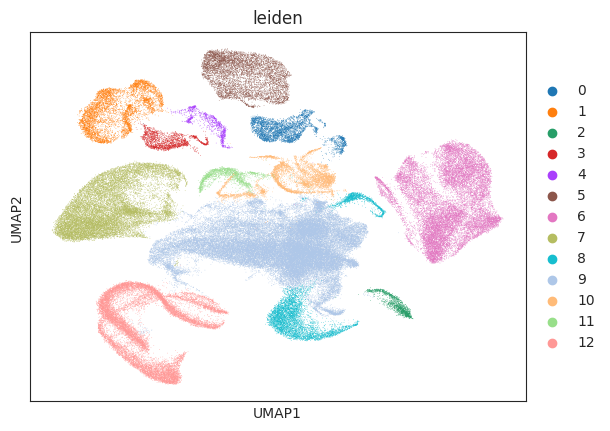

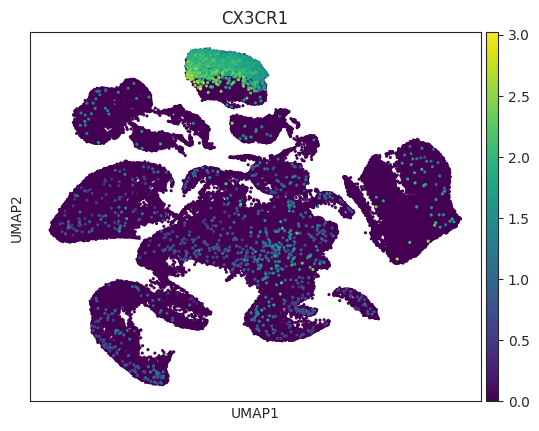

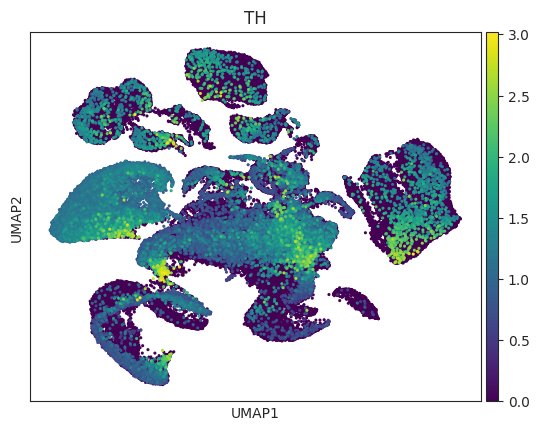

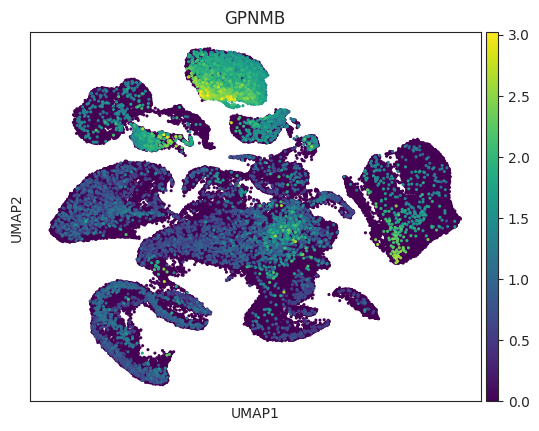

In [40]:
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color="CX3CR1", cmap="viridis", size=20)
sc.pl.umap(adata, color="TH", cmap="viridis", size=20)
sc.pl.umap(adata, color="GPNMB", cmap="viridis", size=20)

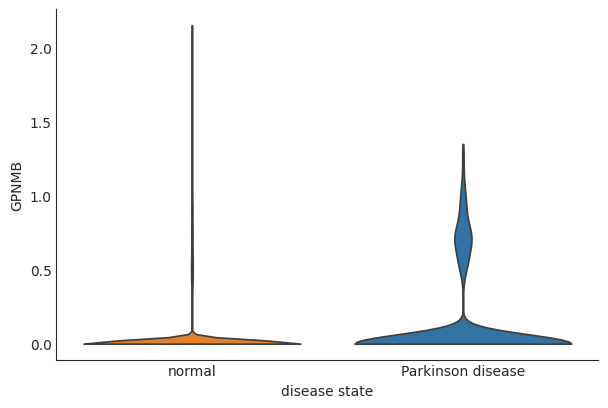

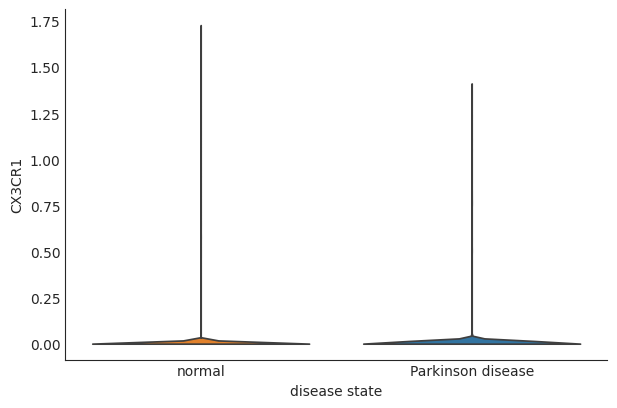

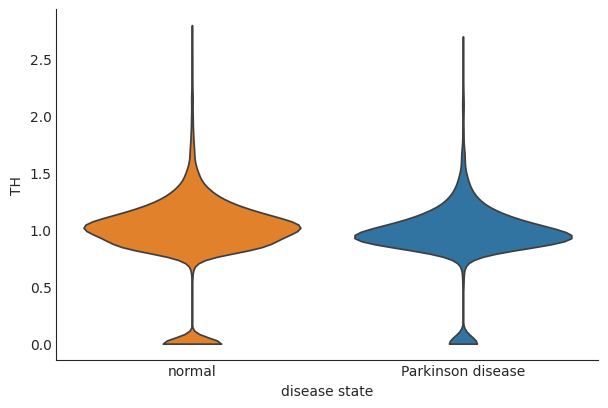

In [41]:
# List of marker genes (replace with your genes of interest)
marker_genes = ["GPNMB", "CX3CR1", "TH"]

order = ["normal", "Parkinson disease"]

# Create individual violin plots for each gene
for i, gene in enumerate(marker_genes):
    # Create the plot for the current gene and store the axes object
    ax = sc.pl.violin(dopamine_subset,
                      keys=gene,                    # Gene of interest
                      groupby="disease_state",              # Grouping by clusters
                      stripplot=False,               # Disable stripplot (no points)
                      jitter=0.4,                    # Adjust jitter for stripplot
                      size=10,                       # Adjust plot size (reduce size to halve the height)
                      order=order,           # Sets the order of the clusters
                      show=False)                    # Avoid immediate display

    # Remove the top and right spines (bounding box lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, remove ticks from the top and right side
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks from top and right

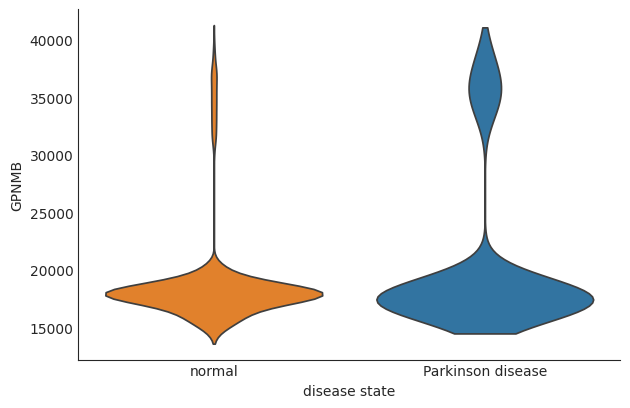

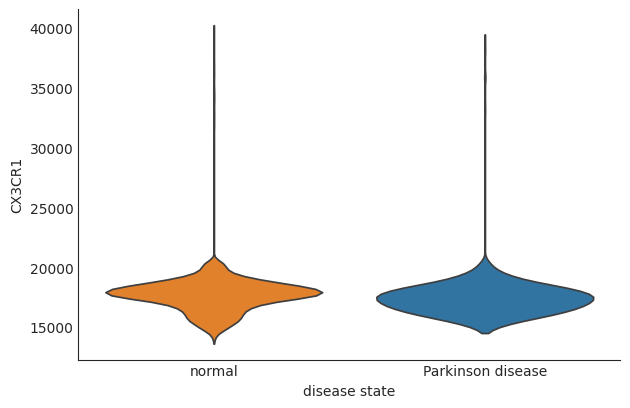

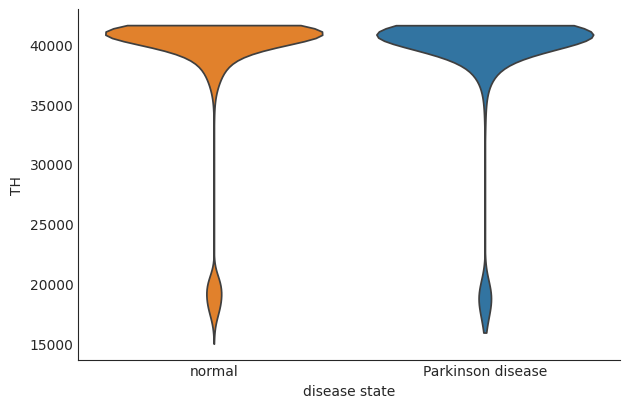

In [42]:
# List of marker genes (replace with your genes of interest)
marker_genes = ["GPNMB", "CX3CR1", "TH"]

order = ["normal", "Parkinson disease"]

# Create individual violin plots for each gene
for i, gene in enumerate(marker_genes):
    # Create the plot for the current gene using the rank-normalized layer
    ax = sc.pl.violin(dopamine_subset,
                      keys=gene,
                      groupby="disease_state",
                      layer="rank",               # <- This line tells it to use the rank-transformed layer
                      stripplot=False,
                      jitter=0.4,
                      size=10,
                      order=order,
                      show=False)

    # Remove the top and right spines (bounding box lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, remove ticks from the top and right side
    ax.tick_params(axis='both', which='both', length=0)


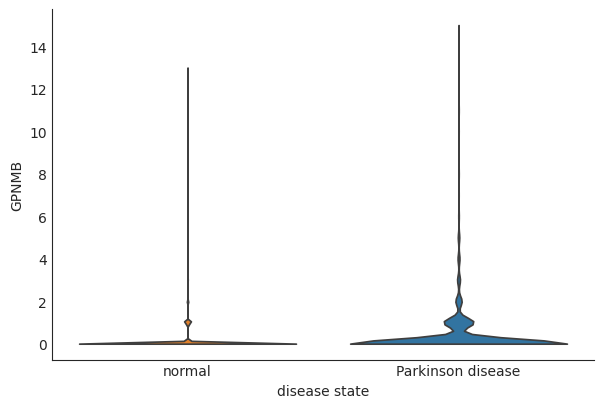

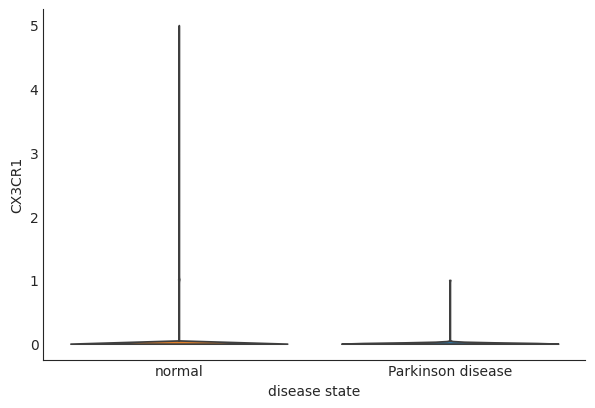

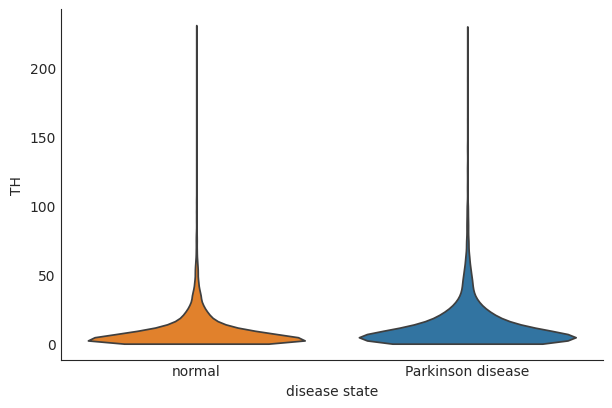

In [43]:
# List of marker genes (replace with your genes of interest)
marker_genes = ["GPNMB", "CX3CR1", "TH"]

order = ["normal", "Parkinson disease"]

# Create individual violin plots for each gene
for i, gene in enumerate(marker_genes):
    # Create the plot for the current gene using the rank-normalized layer
    ax = sc.pl.violin(dopamine_subset,
                      keys=gene,
                      groupby="disease_state",
                      layer="counts",               # <- This line tells it to use the rank-transformed layer
                      stripplot=False,
                      jitter=0.4,
                      size=10,
                      order=order,
                      show=False)

    # Remove the top and right spines (bounding box lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, remove ticks from the top and right side
    ax.tick_params(axis='both', which='both', length=0)

In [51]:
gene_of_interest 'GPNMB'

from scipy.stats import ttest_ind
# import numpy as np
# import pandas as pd

# Extract GPNMB expression (handle sparse if needed)
if hasattr(dopamine_subset[:, gene_of_interest].X, 'toarray'):
    gpnmb_expr = dopamine_subset[:, gene_of_interest].X.toarray().flatten()
else:
    gpnmb_expr = dopamine_subset[:, gene_of_interest].X.flatten()

# Extract disease labels
disease_labels = dopamine_subset.obs['disease_state'].values

# Create DataFrame
df = pd.DataFrame({
    'GPNMB_expression': gpnmb_expr,
    'disease_state': disease_labels
})

# Group statistics
group_stats = df.groupby('disease_state')['GPNMB_expression'].agg(['mean', 'median', 'count'])
print(group_stats)

# Split into groups
expr_normal = df[df['disease_state'] == 'normal']['GPNMB_expression']
expr_pd = df[df['disease_state'] == 'Parkinson disease']['GPNMB_expression']

# Perform t-test
t_stat, p_val = ttest_ind(expr_normal, expr_pd, equal_var=False)  # Welch’s t-test
print(f"\nT-test: t-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")



                       mean  median  count
disease_state                             
Parkinson disease  0.129132     0.0   2215
normal             0.039869     0.0  14879

T-test: t-statistic = -13.93, p-value = 1.768e-42


<ipython-input-51-67f7f5ca10b0>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('disease_state')['GPNMB_expression'].agg(['mean', 'median', 'count'])


In [52]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

gene_of_interest = 'GPNMB'  # Replace with your gene variable

# Extract expression (handle sparse if needed)
if hasattr(dopamine_subset[:, gene_of_interest].X, 'toarray'):
    gene_expr = dopamine_subset[:, gene_of_interest].X.toarray().flatten()
else:
    gene_expr = dopamine_subset[:, gene_of_interest].X.flatten()

# Extract disease labels
disease_labels = dopamine_subset.obs['disease_state'].values

# Create DataFrame dynamically
df = pd.DataFrame({
    f'{gene_of_interest}_expression': gene_expr,
    'disease_state': disease_labels
})

# Group statistics
group_stats = df.groupby('disease_state')[f'{gene_of_interest}_expression'].agg(['mean', 'median', 'count'])
print(f"\n{gene_of_interest} expression summary statistics:")
print(group_stats)

# Split groups
expr_normal = df[df['disease_state'] == 'normal'][f'{gene_of_interest}_expression']
expr_pd = df[df['disease_state'] == 'Parkinson disease'][f'{gene_of_interest}_expression']

# T-test
t_stat, p_val = ttest_ind(expr_normal, expr_pd, equal_var=False)
print(f"\nT-test for {gene_of_interest}: t-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")



GPNMB expression summary statistics:
                       mean  median  count
disease_state                             
Parkinson disease  0.129132     0.0   2215
normal             0.039869     0.0  14879

T-test for GPNMB: t-statistic = -13.93, p-value = 1.768e-42


<ipython-input-52-71f08c22f327>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('disease_state')[f'{gene_of_interest}_expression'].agg(['mean', 'median', 'count'])


In [61]:
# from scipy.stats import ttest_ind

# def analyze_gene_expression(adata, gene_of_interest, groupby='disease_state', group1='normal', group2='Parkinson disease'):
#     """
#     Perform summary statistics and Welch's t-test on gene expression between two groups.

#     Parameters:
#     - adata: AnnData object
#     - gene_of_interest: str, gene name to analyze
#     - groupby: str, column in `adata.obs` to group by (default: 'disease_state')
#     - group1: str, first group name
#     - group2: str, second group name
#     """

#     # Extract expression, handle sparse matrix if needed
#     if hasattr(adata[:, gene_of_interest].X, 'toarray'):
#         gene_expr = adata[:, gene_of_interest].X.toarray().flatten()
#     else:
#         gene_expr = adata[:, gene_of_interest].X.flatten()

#     # Get group labels
#     group_labels = adata.obs[groupby].values

#     # Create DataFrame
#     df = pd.DataFrame({
#         f'{gene_of_interest}_expression': gene_expr,
#         groupby: group_labels
#     })

#     # Summary statistics
#     print(f"\n{gene_of_interest} expression summary by '{groupby}':")
#     group_stats = df.groupby(groupby)[f'{gene_of_interest}_expression'].agg(['mean', 'median', 'count'])
#     print(group_stats)

#     # Extract expression for two groups
#     expr_group1 = df[df[groupby] == group1][f'{gene_of_interest}_expression']
#     expr_group2 = df[df[groupby] == group2][f'{gene_of_interest}_expression']

#     # Perform Welch's t-test
#     t_stat, p_val = ttest_ind(expr_group1, expr_group2, equal_var=False)

#     print(f"\nT-test for {gene_of_interest} ({group1} vs {group2}):")
#     print(f"t-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")

from scipy.stats import ttest_ind
# import numpy as np
# import pandas as pd

def analyze_expression(adata, feature_name, source='gene', groupby='disease_state', group1='normal', group2='Parkinson disease'):
    """
    Analyze expression from a gene (in .X) or a metadata column (in .obs).

    Parameters:
    - adata: AnnData object
    - feature_name: str, gene name or .obs column
    - source: 'gene' or 'obs'
    - groupby: str, .obs column to group by (e.g. 'disease_state')
    - group1: str, name of the first group
    - group2: str, name of the second group
    """

    if source == 'gene':
        if feature_name not in adata.var_names:
            raise ValueError(f"Gene '{feature_name}' not found in adata.var_names.")

        # Extract gene expression
        X = adata[:, feature_name].X
        expr = X.toarray().flatten() if hasattr(X, 'toarray') else X.flatten()

    elif source == 'obs':
        if feature_name not in adata.obs.columns:
            raise ValueError(f"Feature '{feature_name}' not found in adata.obs.")

        expr = adata.obs[feature_name].values

    else:
        raise ValueError("Invalid source. Use 'gene' or 'obs'.")

    # Extract group labels
    group_labels = adata.obs[groupby].values

    # Create DataFrame
    df = pd.DataFrame({
        'value': expr,
        'group': group_labels
    })

    # Summary statistics
    print(f"\nSummary for '{feature_name}' by '{groupby}':")
    group_stats = df.groupby('group')['value'].agg(['mean', 'median', 'count'])
    print(group_stats)

    # T-test
    val1 = df[df['group'] == group1]['value']
    val2 = df[df['group'] == group2]['value']

    t_stat, p_val = ttest_ind(val1, val2, equal_var=False)
    print(f"\nT-test ({group1} vs {group2}):")
    print(f"t-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")


In [65]:
analyze_expression(dopamine_subset,'NUCKS1')


Summary for 'NUCKS1' by 'disease_state':
                       mean    median  count
group                                       
Parkinson disease  0.721850  0.832901   2215
normal             0.745019  0.874107  14879

T-test (normal vs Parkinson disease):
t-statistic = 2.56, p-value = 1.062e-02


<ipython-input-61-83dd92c27589>:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('group')['value'].agg(['mean', 'median', 'count'])


In [67]:
analyze_gene_expression(dopamine_subset,'GPNMB')


GPNMB expression summary by 'disease_state':
                       mean  median  count
disease_state                             
Parkinson disease  0.129132     0.0   2215
normal             0.039869     0.0  14879

T-test for GPNMB (normal vs Parkinson disease):
t-statistic = -13.93, p-value = 1.768e-42


<ipython-input-53-6e12d3bf6f17>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(groupby)[f'{gene_of_interest}_expression'].agg(['mean', 'median', 'count'])


In [69]:
analyze_gene_expression(microglia_subset,'GPNMB')


GPNMB expression summary by 'disease_state':
                       mean    median  count
disease_state                               
Parkinson disease  1.343780  1.618012   2047
normal             0.599215  0.000000   4419

T-test for GPNMB (normal vs Parkinson disease):
t-statistic = -34.79, p-value = 7.926e-235


<ipython-input-53-6e12d3bf6f17>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(groupby)[f'{gene_of_interest}_expression'].agg(['mean', 'median', 'count'])


In [66]:
analyze_expression(dopamine_subset,'glia_score', source='obs')


Summary for 'glia_score' by 'disease_state':
                       mean    median  count
group                                       
Parkinson disease  0.081750  0.069422   2215
normal             0.073953  0.000000  14879

T-test (normal vs Parkinson disease):
t-statistic = -3.64, p-value = 2.754e-04


<ipython-input-61-83dd92c27589>:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('group')['value'].agg(['mean', 'median', 'count'])


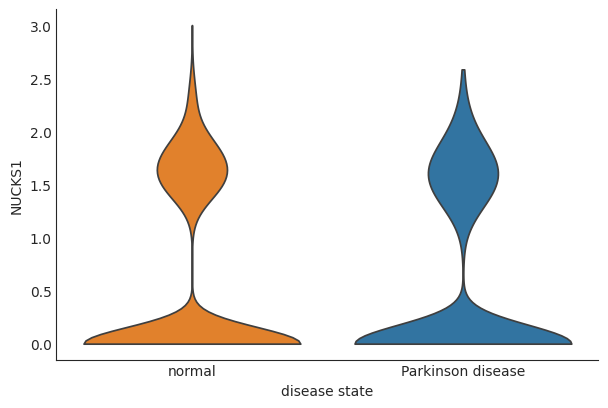

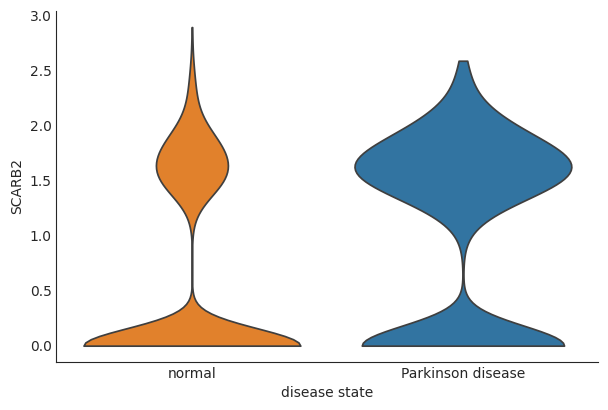

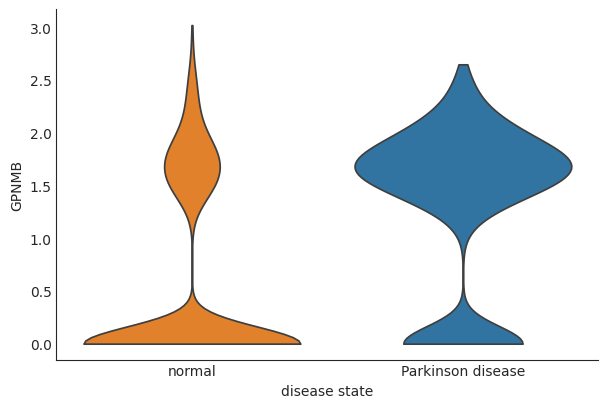

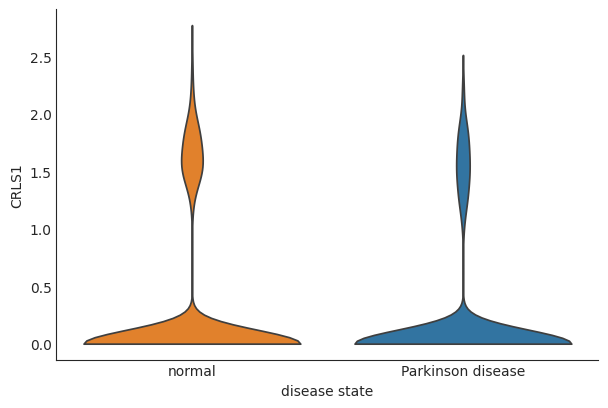

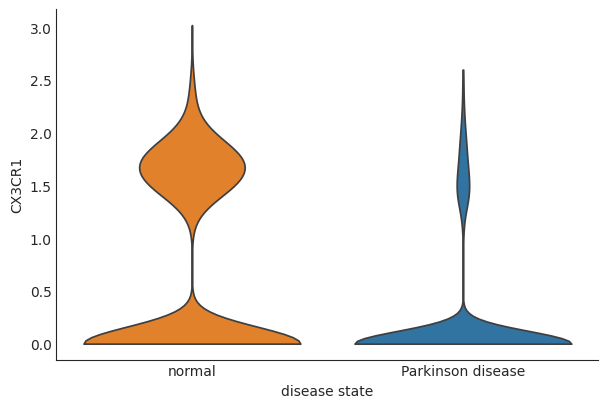

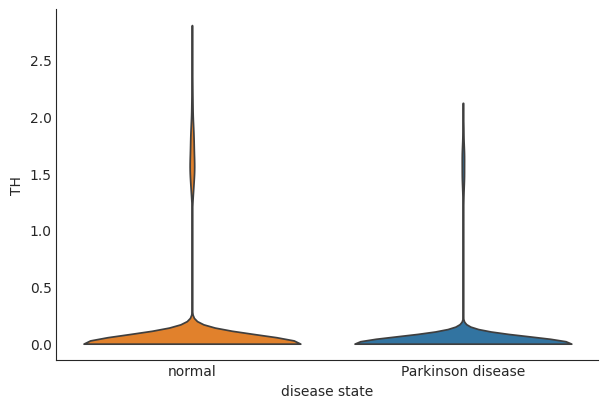

In [68]:
# List of marker genes (replace with your genes of interest)

marker_genes = ["NUCKS1", "SCARB2", "GPNMB", "CRLS1","CX3CR1","TH"]

order = ["normal", "Parkinson disease"]

# Create individual violin plots for each gene
for i, gene in enumerate(marker_genes):
    # Create the plot for the current gene and store the axes object
    ax = sc.pl.violin(microglia_subset,
                      keys=gene,                    # Gene of interest
                      groupby="disease_state",              # Grouping by clusters
                      stripplot=False,               # Disable stripplot (no points)
                      jitter=0.4,                    # Adjust jitter for stripplot
                      size=10,                       # Adjust plot size (reduce size to halve the height)
                      order=order,           # Sets the order of the clusters
                      show=False)                    # Avoid immediate display

    # Remove the top and right spines (bounding box lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, remove ticks from the top and right side
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks from top and right

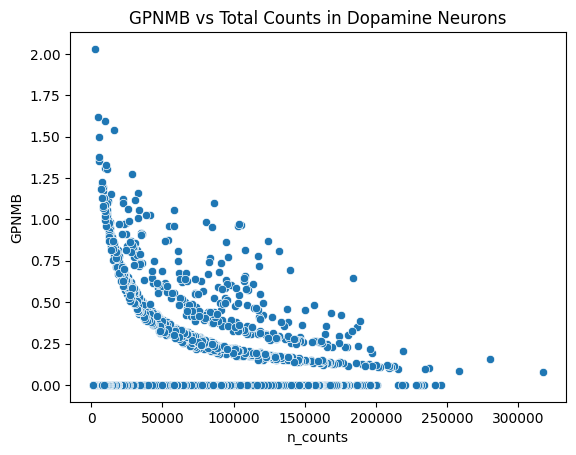

In [19]:
 # check the relationship between GPNMB and microglia marker CX3CR1
import seaborn as sns
import pandas as pd  # Ensure pandas is imported

# Convert to dense array (if sparse) and extract gene expressions
cx3cr1_expr = dopamine_subset[:, 'CX3CR1'].X.toarray().flatten() if hasattr(dopamine_subset[:, 'CX3CR1'].X, 'toarray') else dopamine_subset[:, 'CX3CR1'].X.flatten()
gpnmb_expr = dopamine_subset[:, 'GPNMB'].X.toarray().flatten() if hasattr(dopamine_subset[:, 'GPNMB'].X, 'toarray') else dopamine_subset[:, 'GPNMB'].X.flatten()

n_counts = dopamine_subset.obs['n_counts']  # replace with 'total_counts' or 'nCount_RNA' if that's your column name

# Create dataframe
df = pd.DataFrame({
    'n_counts': n_counts.values,
    'GPNMB': gpnmb_expr
})

# Plot
sns.scatterplot(data=df, x='n_counts', y='GPNMB')
plt.title("GPNMB vs Total Counts in Dopamine Neurons")
plt.show()

In [45]:
glial_markers = ['CX3CR1', 'TMEM119', 'P2RY12', 'AIF1', 'GFAP', 'S100B']

# Create a DataFrame with expression of each marker
glia_expr = pd.DataFrame({
    gene: dopamine_subset[:, gene].X.toarray().flatten() if hasattr(dopamine_subset[:, gene].X, 'toarray') else dopamine_subset[:, gene].X.flatten()
    for gene in glial_markers
}, index=dopamine_subset.obs_names)

# Compute average glial marker expression per cell
glia_expr['glia_score'] = glia_expr.mean(axis=1)

# Add to obs
dopamine_subset.obs['glia_score'] = glia_expr['glia_score']

<ipython-input-49-c4bb204b1546>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


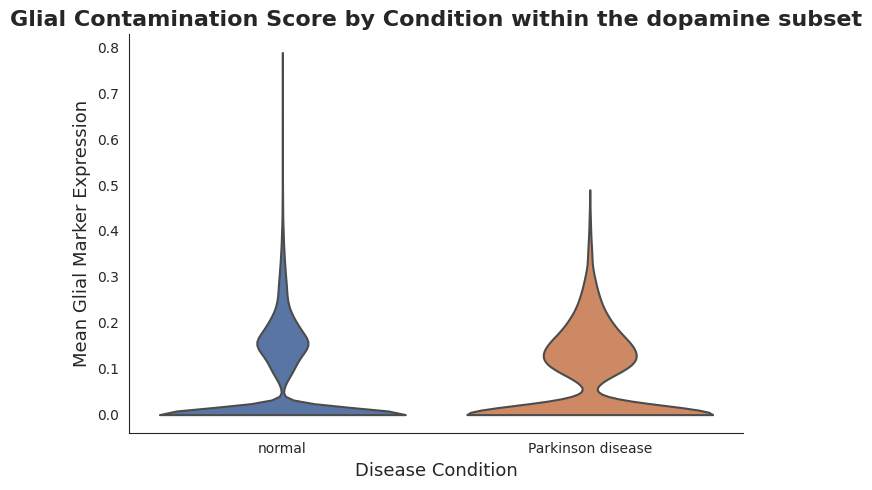

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plain white background with no grid
sns.set_style("white")

# Define color palette and order
palette = {"normal": "#4C72B0", "Parkinson disease": "#DD8452"}
order = ["normal", "Parkinson disease"]

# Create figure
plt.figure(figsize=(7, 5))

# Violin plot (without inner points or boxplot bars)
sns.violinplot(
    data=dopamine_subset.obs,
    x='disease_state',
    y='glia_score',
    palette=palette,
    order=order,
    inner=None,       # Don't show inner boxplot or points
    cut=0,            # Don't extend beyond data range
    linewidth=1.5
)

# Titles and labels
plt.title("Glial Contamination Score by Condition within the dopamine subset", fontsize=16, weight='bold')
plt.ylabel("Mean Glial Marker Expression", fontsize=13)
plt.xlabel("Disease Condition", fontsize=13)

# Remove gridlines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()
plt.show()


In [47]:
from scipy.stats import pearsonr

r_counts, p_counts = pearsonr(dopamine_subset.obs['glia_score'], dopamine_subset.obs['n_counts'])
print(f"Glia score vs n_counts: r = {r_counts:.3f}, p = {p_counts:.3e}")

Glia score vs n_counts: r = 0.167, p = 2.405e-107


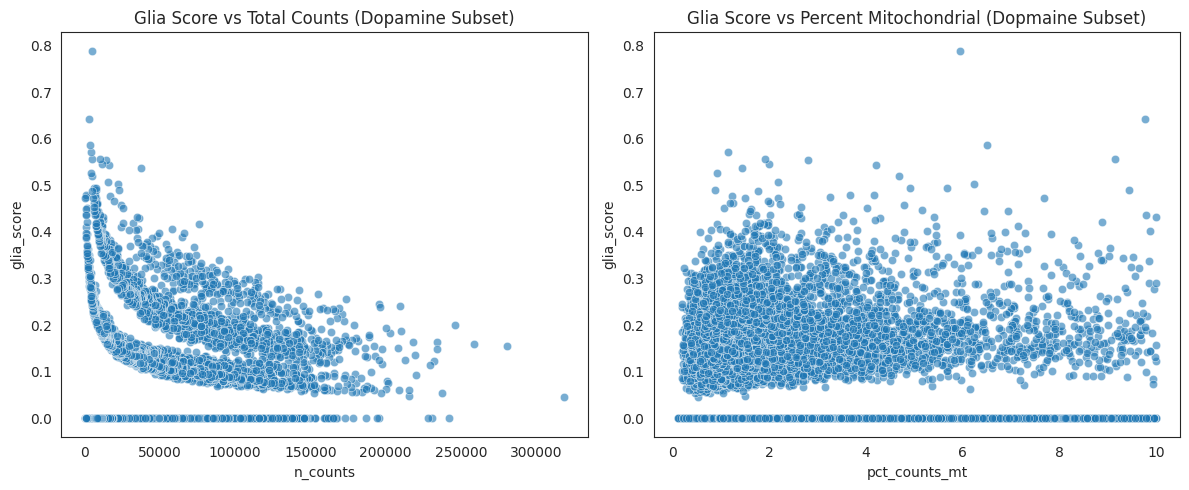

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Glia Score vs Total Counts
sns.scatterplot(data=dopamine_subset.obs, x='n_counts', y='glia_score', alpha=0.6, ax=axes[0])
axes[0].set_title("Glia Score vs Total Counts (Dopamine Subset)")

# Glia Score vs Percent Mitochondrial
sns.scatterplot(data=dopamine_subset.obs, x='pct_counts_mt', y='glia_score', alpha=0.6, ax=axes[1])
axes[1].set_title("Glia Score vs Percent Mitochondrial (Dopmaine Subset)")

plt.tight_layout()
plt.show()

In [70]:
print('test')

test
